# Final Project: Emotion Analysis on 1.6 million tweets

### <span style="color:chocolate"> Motivation </span>


*   The model can be used for personalized content recommendations, such as advertisements, public postings, and interactions.
*   The model can be used for tracking people's attitude towards certain social events.





### <span style="color:chocolate"> Data Source </span>

We would perform sentiment analysis with 1,600,000 tweets extracted from twitter. It contains the following 6 fields:


*   **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
*   **ids**: The id of the tweet ( 2087)
*   **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
*   **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.

*   **user**: the user that tweeted (robotickilldozr)

*   **text**: the text of the tweet (Lyx is cool)

According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

The original dataset is from Kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140

---
### Import Libraries and load data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load dataset
file_path = '/content/drive/MyDrive/w207 Final Project/tweets.csv'

# Load the CSV file
df_full = pd.read_csv(file_path, encoding='latin1', header=None)
df = df_full.sample(frac=0.025, random_state=1)
print(df.shape)

(40000, 6)


In [4]:
# Assign column names
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
sentiment_map = {0: "negative", 2: "neutral", 4: "positive"}
def convert_label(x):
  return sentiment_map[x]
df['sentiment'] = df['target'].apply(convert_label)
df.head()

,target,ids,date,flag,user,text,sentiment
514293,0,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...,negative
142282,0,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,So I had a dream last night. I remember a sig...,negative
403727,0,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,@girlyghost ohh poor sickly you (((hugs)) ho...,negative
649503,0,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again,negative
610789,0,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,@MissKeriBaby wish I was in LA right now,negative


In [5]:
# Check different values of the target variable and count each one
target_counts = df['target'].value_counts()
print("Target value counts:\n", target_counts)

Target value counts:
 target
4    20047
0    19953
Name: count, dtype: int64


In [6]:
#Check for missing values
print(df.isnull().sum())

target       0
ids          0
date         0
flag         0
user         0
text         0
sentiment    0
dtype: int64


### 🔦Exploratory Data Analysis

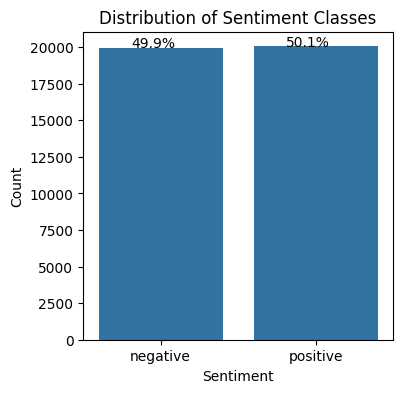

In [7]:
#Plotting of sentiment distribution - not necessary at all since it is 50/50
plt.figure(figsize=(4,4))
ax = sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Calculate the percentages and annotate each bar
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

Plot of the tweet lengths distribution - Based on the plot, 100 will be a reasonable cut.

In [8]:
tweets = df['text']
labels = df['target']

positive = []
negative = []

for x,y in zip(tweets, labels):
  if y == 4:
    positive.append(len(x))
  elif y == 0:
    negative.append(len(x))
print(f'Positive review length: minimum: {min(positive)}, maximum: {max(positive)}, mean: {np.array(positive).mean()}')
print(f'Negative review length: minimum: {min(negative)}, maximum: {max(negative)}, mean: {np.array(negative).mean()}')

Positive review length: minimum: 8, maximum: 220, mean: 73.60398064548312
Negative review length: minimum: 6, maximum: 201, mean: 73.97098180724703


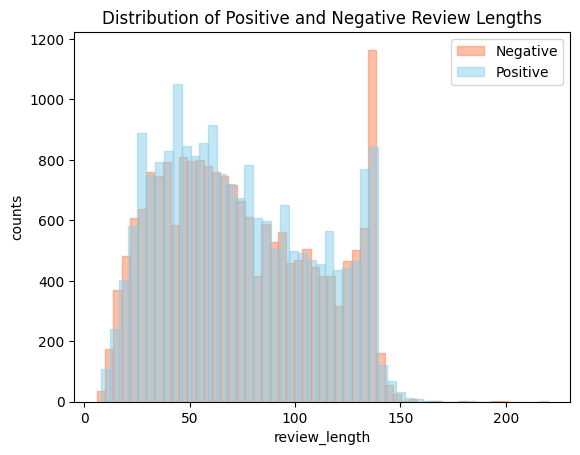

In [9]:
plt.hist(negative, bins = 50, label='Negative', color='coral', ec='coral', alpha=0.5)
plt.hist(positive, bins = 50, label='Positive', color="skyblue", ec='skyblue', alpha=0.5)
plt.xlabel('review_length')
plt.ylabel('counts')
plt.title('Distribution of Positive and Negative Review Lengths')
plt.legend(loc="upper right")
plt.show()

### ✂️Data Preprocessing

In [10]:
# Preprocess the text data
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)  # Remove URLs
df['text'] = df['text'].str.replace(r'@\w+', '', regex=True)     # Remove mentions
df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)     # Remove hashtags
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Remove special characters

In [11]:
df.head()

,target,ids,date,flag,user,text,sentiment
514293,0,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...,negative
142282,0,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,so i had a dream last night i remember a sign...,negative
403727,0,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,ohh poor sickly you hugs hope you feel a li...,negative
649503,0,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again,negative
610789,0,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,wish i was in la right now,negative


In [12]:
%%time
# Tokenization and Padding
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=100)


CPU times: user 1.13 s, sys: 15.1 ms, total: 1.15 s
Wall time: 1.14 s


In [13]:
# Adjust labels for binary classification (0 for negative, 1 for positive)
y = df['target'].apply(lambda x: 0 if x == 0 else 1).values

In [14]:
df.head()

,target,ids,date,flag,user,text,sentiment
514293,0,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...,negative
142282,0,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,so i had a dream last night i remember a sign...,negative
403727,0,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,ohh poor sickly you hugs hope you feel a li...,negative
649503,0,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again,negative
610789,0,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,wish i was in la right now,negative


In [15]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to categorical format for binary classification
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Print shapes of the datasets
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (32000, 100)
Shape of y_train: (32000, 2)
Shape of X_val: (4000, 100)
Shape of y_val: (4000, 2)
Shape of X_test: (4000, 100)
Shape of y_test: (4000, 2)


### 🌱Baseline Model & Hyperparameter Tuning

### Baseline Regression Model

In [16]:
# Build baseline model: logistic regression
def build_baseline_model(learning_rate = 0.001):

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(100,)))

  model.add(tf.keras.layers.Dense(
      units=2,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), # default learning rate is 0.001
                metrics=['accuracy'])

  return model

Hyperparameter Tuning - Baseline Model

In [17]:
# Plotting function
def plot_metrics(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 4))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Training and validation loss\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [18]:
# Adding early stop if the loss becomes stable at early epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
'''
%%time
# Fine hypertuning for model1
learning_rate = [0.01, 0.001, 0.0005]
epochs = [5, 10, 15]

for l in learning_rate:
  for e in epochs:
    model1 = build_baseline_model(learning_rate = l)
    model1_history = model1.fit(
        x = X_train,
        y = y_train,          # corresponding binary labels
        epochs=e,             # number of passes through the training data
        batch_size=64,        # mini-batch size
        validation_data=(X_val, y_val), # use a fraction of the examples for validation
        verbose=0,
        callbacks=early_stopping
        )
    val_loss = model1_history.history['val_loss'][-1]
    val_accuracy = model1_history.history['val_accuracy'][-1]
    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
    plot_metrics(model1_history, f'Learning Rate: {l}, Epochs: {e}')
    print('\n')
'''

"\n%%time\n# Fine hypertuning for model1\nlearning_rate = [0.01, 0.001, 0.0005]\nepochs = [5, 10, 15]\n\nfor l in learning_rate:\n  for e in epochs:\n    model1 = build_baseline_model(learning_rate = l)\n    model1_history = model1.fit(\n        x = X_train,\n        y = y_train,          # corresponding binary labels\n        epochs=e,             # number of passes through the training data\n        batch_size=64,        # mini-batch size\n        validation_data=(X_val, y_val), # use a fraction of the examples for validation\n        verbose=0,\n        callbacks=early_stopping\n        )\n    val_loss = model1_history.history['val_loss'][-1]\n    val_accuracy = model1_history.history['val_accuracy'][-1]\n    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')\n    plot_metrics(model1_history, f'Learning Rate: {l}, Epochs: {e}')\n    print('\n')\n"

Final Baseline Model

In [19]:
%%time
# Finalize Baseline Model: Learning_rate = 0.0005, epochs = 15
model1 = build_baseline_model(learning_rate = 0.0005)
model1_history = model1.fit(
    x = X_train,
    y = y_train,          # corresponding binary labels
    epochs=15,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_data=(X_val, y_val), # use a fraction of the examples for validation
    verbose=0
    )

model1_score, model1_acc = model1.evaluate(X_test, y_test, batch_size=64)
print('Logistic Regression Baseline Test accuracy:', model1_acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.7322 - accuracy: 0.5238
Logistic Regression Baseline Test accuracy: 0.5237500071525574
CPU times: user 18.2 s, sys: 2.13 s, total: 20.3 s
Wall time: 16.5 s


### ⭐Improvements

### FNN Model

In [20]:
%%time
# Feedforward Neural Network (FNN)
fnn_model = Sequential()
fnn_model.add(Embedding(input_dim=20000, output_dim=128, input_length=100))
fnn_model.add(Flatten())
fnn_model.add(Dense(64, activation='relu'))
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dense(2, activation='softmax'))

# Compile FNN model
fnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train FNN model
fnn_history = fnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate FNN model
baseline_score, baseline_acc = fnn_model.evaluate(X_test, y_test, batch_size=32)
print('FNN Baseline Test accuracy:', baseline_acc)

Epoch 1/5
1000/1000 [==============================] - 13s 12ms/step - loss: 0.5435 - accuracy: 0.7188 - val_loss: 0.4919 - val_accuracy: 0.7605
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4453 - accuracy: 0.7930 - val_loss: 0.5086 - val_accuracy: 0.7538
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3575 - accuracy: 0.8411 - val_loss: 0.5702 - val_accuracy: 0.7398
Epoch 4/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2614 - accuracy: 0.8879 - val_loss: 0.7163 - val_accuracy: 0.7325
Epoch 5/5
125/125 [==============================] - 0s 2ms/step - loss: 0.8437 - accuracy: 0.7352
FNN Baseline Test accuracy: 0.7352499961853027
CPU times: user 31.9 s, sys: 2.71 s, total: 34.6 s
Wall time: 27.1 s


### CNN Model

In [21]:
%%time
# CNN model
def build_cnn_model(pool_size = 3):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cnn_model = Sequential()
  cnn_model.add(tf.keras.layers.Input(shape=(100,)))
  cnn_model.add(Embedding(input_dim=4000, output_dim=128, input_length=100))
  cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
  cnn_model.add(MaxPooling1D(pool_size=pool_size))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Dense(2, activation='softmax'))

  cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return cnn_model


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [ ]:
'''
%%time
# Fine hypertuning for cnn_model
pool_sizes = [2, 4, 6]
epochs = [5, 10, 15]
for p in pool_sizes:
  for e in epochs:
    cnn_model = build_cnn_model(pool_size = p)
    cnn_history = cnn_model.fit(X_train, y_train, epochs=e, batch_size=64, validation_data=(X_val, y_val), verbose=0, callbacks=early_stopping)
    val_loss = cnn_history.history['val_loss'][-1]
    val_accuracy = cnn_history.history['val_accuracy'][-1]
    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
    plot_metrics(cnn_history, f'Pool Size: {p}, Epochs: {e}')
    print('\n')
'''

"\n%%time\n# Fine hypertuning for cnn_model\npool_sizes = [2, 4, 6]\nepochs = [5, 10, 15]\nfor p in pool_sizes:\n  for e in epochs:\n    cnn_model = build_cnn_model(pool_size = p)\n    cnn_history = cnn_model.fit(X_train, y_train, epochs=e, batch_size=64, validation_data=(X_val, y_val), verbose=0, callbacks=early_stopping)\n    val_loss = cnn_history.history['val_loss'][-1]\n    val_accuracy = cnn_history.history['val_accuracy'][-1]\n    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')\n    plot_metrics(cnn_history, f'Pool Size: {p}, Epochs: {e}')\n    print('\n')\n"

In [22]:
# The final model: pool size: 2, epochs = 10
cnn_model = build_cnn_model(pool_size = 4)
cnn_history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=early_stopping)

cnn_score, cnn_acc = cnn_model.evaluate(X_test, y_test, batch_size=64)
print('CNN Model Test accuracy:', cnn_acc)

Epoch 1/5
500/500 [==============================] - 14s 20ms/step - loss: 0.5677 - accuracy: 0.6970 - val_loss: 0.4874 - val_accuracy: 0.7667
Epoch 2/5
500/500 [==============================] - 2s 5ms/step - loss: 0.4662 - accuracy: 0.7868 - val_loss: 0.4798 - val_accuracy: 0.7745
Epoch 3/5
500/500 [==============================] - 2s 5ms/step - loss: 0.3972 - accuracy: 0.8227 - val_loss: 0.5238 - val_accuracy: 0.7700
Epoch 4/5
500/500 [==============================] - 2s 5ms/step - loss: 0.3077 - accuracy: 0.8701 - val_loss: 0.6614 - val_accuracy: 0.7527
Epoch 5/5
63/63 [==============================] - 0s 2ms/step - loss: 0.7488 - accuracy: 0.7427
CNN Model Test accuracy: 0.7427499890327454


### CNN Model Improvement - Replacing Embedding Layers with Word2Vec

Hyperparameter Tuning - Embedding Layer

In [23]:
%%time
import gensim.downloader as api

# Load Google's pre-trained Word2Vec model
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
CPU times: user 5min 4s, sys: 47.8 s, total: 5min 52s
Wall time: 5min 26s


In [24]:
# Create embedding matrix
'''
The result is a set of word vectors, where each word is represented by
a vector of fixed dimensionality (300 dimensions).
These vectors capture semantic relationships between words,
meaning that words with similar meanings are close to each other in the vector space.
'''
word_index = tokenizer.word_index
embedding_dim = 300  # Google Word2Vec uses 300-dimensional vectors
embedding_matrix = np.zeros((4000, embedding_dim))

for word, i in word_index.items():
    if i < 4000:
        try:
            embedding_vector = word2vec[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Words not found in the Word2Vec model will be all zeros.
            embedding_matrix[i] = np.random.randn(embedding_dim)

In [25]:
def build_cnn_model2(pool_size=3, embedding_dim=300):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    cnn_model = Sequential()
    cnn_model.add(tf.keras.layers.Input(shape=(100,)))
    cnn_model.add(Embedding(input_dim=4000,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False))
    cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=pool_size))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(2, activation='sigmoid'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn_model

In [26]:
'''
%%time
pool_sizes = [3, 6, 9]
epochs = [5, 10, 15]

for p in pool_sizes:
  for e in epochs:
    cnn_model2 = build_cnn_model2(pool_size=p)
    cnn_model2_history = cnn_model2.fit(
        x = X_train,
        y = y_train,          # corresponding binary labels
        epochs=e,             # number of passes through the training data
        batch_size=64,        # mini-batch size
        validation_data=(X_val, y_val), # use a fraction of the examples for validation
        verbose=0,
        callbacks=early_stopping
        )
    val_loss = cnn_model2_history.history['val_loss'][-1]
    val_accuracy = cnn_model2_history.history['val_accuracy'][-1]
    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
    plot_metrics(cnn_model2_history, f'Pool Size: {p}, Epochs: {e}')
    print('\n')
'''

"\n%%time\npool_sizes = [3, 6, 9]\nepochs = [5, 10, 15]\n\nfor p in pool_sizes:\n  for e in epochs:\n    cnn_model2 = build_cnn_model2(pool_size=p)\n    cnn_model2_history = cnn_model2.fit(\n        x = X_train,\n        y = y_train,          # corresponding binary labels\n        epochs=e,             # number of passes through the training data\n        batch_size=64,        # mini-batch size\n        validation_data=(X_val, y_val), # use a fraction of the examples for validation\n        verbose=0,\n        callbacks=early_stopping\n        )\n    val_loss = cnn_model2_history.history['val_loss'][-1]\n    val_accuracy = cnn_model2_history.history['val_accuracy'][-1]\n    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')\n    plot_metrics(cnn_model2_history, f'Pool Size: {p}, Epochs: {e}')\n    print('\n')\n"

In [27]:
# The final improved cnn model: pool size: 6, epochs = 5
cnn_model2 = build_cnn_model2(pool_size = 4)
cnn_history2 = cnn_model2.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=early_stopping)

cnn_score2, cnn_acc2 = cnn_model2.evaluate(X_test, y_test, batch_size=64)
print('CNN Model Test accuracy:', cnn_acc)

Epoch 1/5
500/500 [==============================] - 4s 4ms/step - loss: 0.6515 - accuracy: 0.6133 - val_loss: 0.5536 - val_accuracy: 0.7175
Epoch 2/5
500/500 [==============================] - 2s 3ms/step - loss: 0.5452 - accuracy: 0.7295 - val_loss: 0.5180 - val_accuracy: 0.7495
Epoch 3/5
500/500 [==============================] - 2s 3ms/step - loss: 0.5129 - accuracy: 0.7509 - val_loss: 0.5114 - val_accuracy: 0.7460
Epoch 4/5
500/500 [==============================] - 2s 3ms/step - loss: 0.4833 - accuracy: 0.7703 - val_loss: 0.5190 - val_accuracy: 0.7515
Epoch 5/5
63/63 [==============================] - 0s 2ms/step - loss: 0.5268 - accuracy: 0.7495
CNN Model Test accuracy: 0.7427499890327454


### 📊Plotting

### Metrics Plot

In [28]:
# Plotting function
def plot_metrics(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 4))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Training and validation loss\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



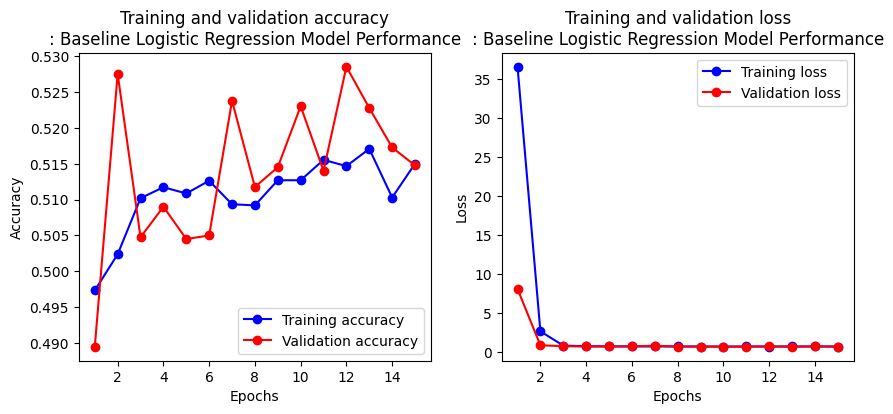

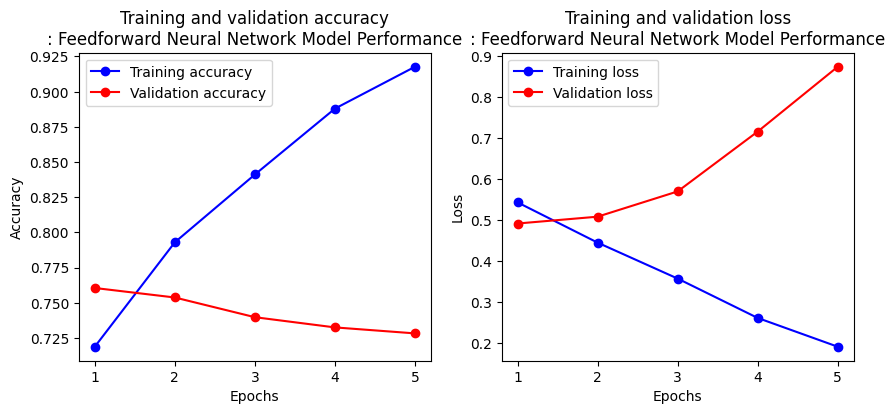

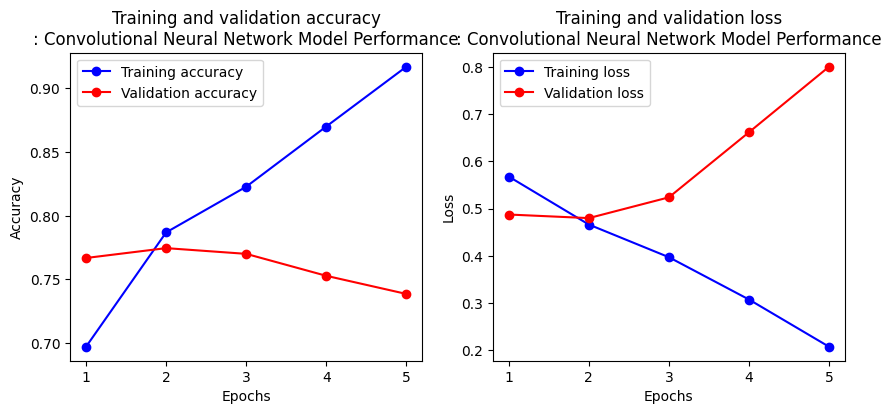

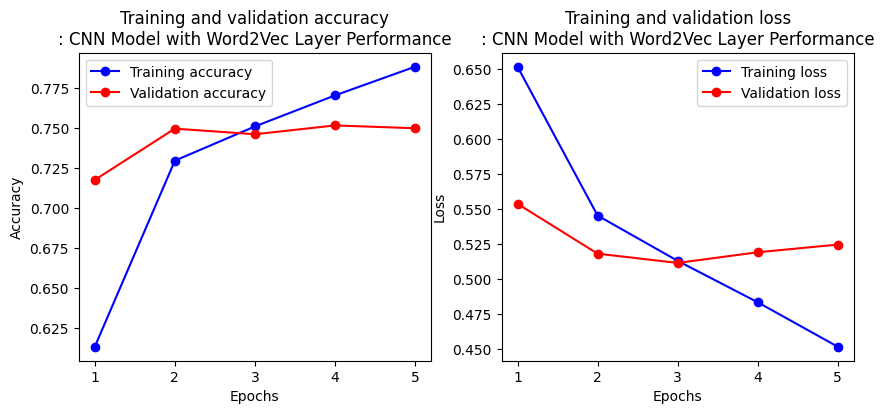

In [29]:
plot_metrics(model1_history, 'Baseline Logistic Regression Model Performance')
plot_metrics(fnn_history, 'Feedforward Neural Network Model Performance')
plot_metrics(cnn_history, 'Convolutional Neural Network Model Performance')
plot_metrics(cnn_history2, 'CNN Model with Word2Vec Layer Performance')


### Performance Table

In [30]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate a model and return its performance metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    return accuracy, precision, recall, f1

# Assuming you have 4 models already trained
models = [model1, fnn_model, cnn_model, cnn_model2]
model_names = ['Baseline Model', 'FNN Model', 'CNN Model', 'CNN Model 2']

# Collect performance metrics for each model
performance_data = []

for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    performance_data.append([name, accuracy, precision, recall, f1])

# Create a DataFrame to display the results
performance_df = pd.DataFrame(performance_data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the performance table
print(performance_df)


125/125 [==============================] - 0s 2ms/step
            Model  Accuracy  Precision   Recall  F1 Score
0  Baseline Model   0.52375   0.523457  0.52375  0.522028
1       FNN Model   0.73525   0.735259  0.73525  0.735253
2       CNN Model   0.74275   0.744016  0.74275  0.742560
3     CNN Model 2   0.74950   0.749569  0.74950  0.749435


### ROC-AUC table

125/125 [==============================] - 0s 1ms/step
1 1
125/125 [==============================] - 0s 2ms/step
1 0
125/125 [==============================] - 0s 2ms/step
1 1
125/125 [==============================] - 0s 2ms/step
1 1


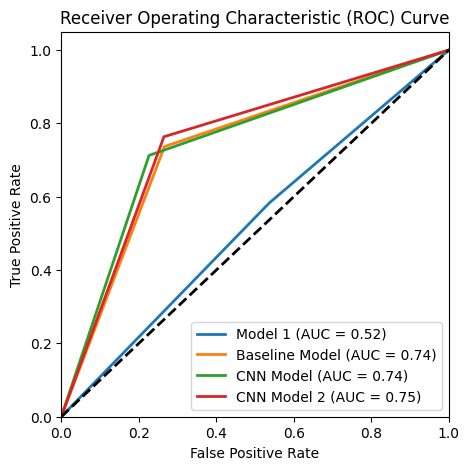

In [32]:
# Function to plot ROC curve for a model

def plot_roc_curve(model, X_test, y_test, model_name, ax):
    if y_test.ndim > 1 and y_test.shape[1] > 1:
      y_test = np.argmax(y_test, axis=1)
    y_pred_proba = np.argmax(model.predict(X_test), axis=1)
    print(y_test[0], y_pred_proba[0])

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Assuming you have 4 models already trained and their names
models = [model1, fnn_model, cnn_model, cnn_model2]
model_names = ['Model 1', 'Baseline Model', 'CNN Model', 'CNN Model 2']

# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot ROC curves for each model
for model, name in zip(models, model_names):
    plot_roc_curve(model, X_test, y_test, name, ax)

# Plot the diagonal line for reference
ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

# Show the plot
plt.show()


### Plot Word Embeddings


In [33]:
# Display the model layers.
display(cnn_model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = cnn_model2.layers[0].get_weights()[0]
display(embeddings2.shape)

(4000, 300)

In [39]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])
'''
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'
'''
max_id = max(reverse_index.keys())
print('Largest ID:', max_id)


Largest ID: 34867


In [52]:
import plotly.graph_objs as go

def plot_2d_embeddings(embeddings, id_start=1, count=100, title="Word Embeddings", x_label="PCA Component 1", y_label="PCA Component 2"):
    # Get 1st and 2nd embedding dims for the desired tokens.
    x1 = embeddings[id_start:id_start+count, 0]
    x2 = embeddings[id_start:id_start+count, 1]

    # Get the corresponding words from the reverse index (for labeling).
    tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

    color_scale = np.linspace(0, 1, count)

    # Plot with the plotly library.
    data = go.Scatter(
        x=x1,
        y=x2,
        text=tokens,
        mode='markers+text',
        textposition='bottom right',
        hoverinfo='text',
        marker=dict(
            size=10,
            color=color_scale,
            colorscale='Viridis',
            showscale=True,
        )
    )

    layout = go.Layout(
        title=title,
        xaxis=dict(title=x_label),
        yaxis=dict(title=y_label),
        hovermode='closest'
    )

    fig = go.Figure(data=[data], layout=layout)
    fig.show()

plot_2d_embeddings(embeddings2,
                   title='Word Embeddings for CNN Model2',
                   id_start=1000,
                   count=100)
